In [1]:
# IMPORT STATEMENTS
import re
import numpy as np
from matplotlib import pyplot as plt
get_ipython().magic('matplotlib inline')
import pandas as pd
from collections import Counter
import os
import sys
sys.path.append("/booleanfs2/sahoo/Hegemon/")
sys.path.append("BoNE")
import StepMiner as smn
import HegemonUtil as hu
acolor = ["#00CC00", "#D8A03D","#EC008C",
          'cyan', "#B741DC", "#808285",
          'blue', 'black', 'green', 'red',
          'orange', 'brown', 'pink', 'purple']

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
import bone
reload(bone)
class MacAnalysis(bone.MacAnalysis):

    def __init__(self):
        bone.MacAnalysis.__init__(self)
   
 

       
    
def plotViolinBar(ana, desc=None):
    fig = plt.figure(figsize=(5,5), dpi=100)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    ax1 = plt.subplot2grid((4, 1), (0, 0))
    ax2 = plt.subplot2grid((4, 1), (1, 0), rowspan=3)
    params = {'spaceAnn': len(ana.order)/len(ana.atypes), 'tAnn': 1, 'widthAnn':1,
              'genes': [], 'ax': ax1, 'acolor': acolor}
    ax = ana.printTitleBar(params)
    res = ana.getROCAUC()
    ax.text(len(ana.cval[0]), 4, res)
    if desc is not None:
        ax.text(-1, 2, desc, horizontalalignment='right',
                    verticalalignment='center')
    params = {'spaceAnn': len(ana.order)/len(ana.atypes), 'tAnn': 1, 'widthAnn':1,
            'genes': [], 'ax': ax2, 'acolor': acolor, 'vert': 0}
    ax = ana.printViolin(None, params)
    return fig

def plotDensityBar(ana, desc=None):
    fig = plt.figure(figsize=(4,4), dpi=100)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    ax1 = plt.subplot2grid((4, 1), (0, 0))
    ax2 = plt.subplot2grid((4, 1), (1, 0), rowspan=3)
    params = {'spaceAnn': len(ana.order)/len(ana.atypes), 'tAnn': 1, 'widthAnn':1,
              'genes': [], 'ax': ax1, 'acolor': acolor}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    ax.text(len(ana.cval[0]), 4, ",".join(res))
    if desc is not None:
        ax.text(-1, 2, desc, horizontalalignment='right',
                    verticalalignment='center')
    ax = ana.densityPlot(ax2, acolor)
    return fig

def processData(ana, l1, wt1, desc=None, violin=1):
    ana.orderData(l1, wt1)
    if (violin == 1):
        return plotViolinBar(ana, desc)
    return plotDensityBar(ana, desc)

def processDataDf(ana, l1, wt1, desc=None):
    fig = plt.figure(figsize=(4,4), dpi=100)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    ax1 = plt.subplot2grid((4, 1), (0, 0))
    ax2 = plt.subplot2grid((4, 1), (1, 0), rowspan=3)

    c_dict, fpr, tpr, roc_auc = bone.processGeneGroupsDf(ana, l1, wt1)
    params = {'spaceAnn': len(ana.order)/len(ana.atypes), 'tAnn': 1, 'widthAnn':1,
              'genes': [], 'ax': ax1, 'acolor': acolor}
    ax = ana.printTitleBar(params)
    res = ana.getROCAUC()
    ax.text(len(ana.cval[0]), 4, res)
    if desc is not None:
        ax.text(-1, 2, desc, horizontalalignment='right',
                    verticalalignment='center')
    params = {'spaceAnn': len(ana.order)/len(ana.atypes), 'tAnn': 1, 'widthAnn':1,
            'genes': [], 'ax': ax2, 'acolor': acolor, 'vert': 0}
    ax = ana.printViolin(None, params)
    return fig


def getOrder(ana, l1):
    from scipy.stats import fisher_exact, ttest_ind
    res = []
    for s in l1:
        for gn in s:
            id1 = ana.h.getBestID(ana.h.getIDs(gn).keys())
            if id1 is None:
                continue
            e = ana.h.getExprData(id1)
            v1 = np.array([float(e[i]) if e[i] != "" else 0 for i in ana.state[0]])
            v2 = np.array([float(e[i]) if e[i] != "" else 0 for i in ana.state[1]])
            t, p = ttest_ind(v1,v2,equal_var=False)
            res += [[id1, ana.h.getSimpleName(id1),
                   t, p, np.mean(v1)-np.mean(v2)]]
    return pd.DataFrame(res, columns=['ProbeID', 'Name', 'T', 'p', 'Diff'])
def plotVolcano(ana, genes, cfile, ylim=[0, 10.5], xlim=[-6, 6]):
    df = processGenes(ana.h, [ana.state[0], ana.state[1]], genes)
    df['Size'] = 10
    fig,ax = plt.subplots(figsize=(6,4), dpi=100)
    crcdf = pd.read_csv(cfile)
    crcdf['logp'] = -np.log10(crcdf['pvalue'])
    ax = sns.scatterplot('log2FoldChange', 'logp', size=0.1, color='0.8',
                         edgecolor="none", data=crcdf)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.legend().set_visible(False)
    import io
    import base64
    buffer = io.BytesIO()
    fig.savefig(buffer, format='jpg')
    buffer.seek(0)
    volcano = base64.b64encode(buffer.read())
    from PIL import Image, ImageDraw
    buffer.seek(0)
    img = Image.open(buffer)
    x = list(ax.bbox.bounds)
    x[2] = x[2] + x[0]
    x[3] = x[3] + x[1] - 2
    x[1] = x[1] - 2
    img = img.crop(x)

    fig,ax = plt.subplots(figsize=(6,4), dpi=100)
    ax = sns.scatterplot('Diff', 'logp', hue='Diff', palette='vlag',
                         data=df, size='Size', size_norm=(0, 10), 
                         edgecolor="none", zorder=2, ax=ax)
    ax.legend().set_visible(False)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    for i in df.index:
        ax.text(df['Diff'][i]+.02, df['logp'][i], str(df['Name'][i]))
    ax.imshow(img,
              aspect = ax.get_aspect(),
              extent = ax.get_xlim() + ax.get_ylim(),
              zorder = 1) #put the map under the heatmap
    return ax

def savePList(ofile, ana, l1):
    df = getOrder(ana, l1)
    df1 = df.sort_values(by=['T'], ascending=True)
    bone.saveList(ofile, df1['Name'])

def getSViP():
    l1 = [bone.readList("/booleanfs2/sahoo/Data/Macrophage/BN/covid/iav-list-1.txt")[0:20]] # 20 gene signature
    wt1 = [1]
    return wt1, l1

def getViP():
    l1 = [bone.readList("/booleanfs2/sahoo/Data/Macrophage/BN/covid/list-2.txt")] # 166 gene signature
    wt1 = [1]
    return wt1, l1

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
def getPDF(cfile):
    import bone
    reload(bone)
    from matplotlib.backends.backend_pdf import PdfPages

    pdf = PdfPages(cfile)
    return pdf

def closePDF(pdf):
    import datetime
    d = pdf.infodict()
    d['Title'] = 'Plots'
    d['Author'] = 'Daniella Vo'
    d['Subject'] = "Microbe Polyp"
    d['Keywords'] = 'disease training validation ROC'
    d['CreationDate'] = datetime.datetime(2021, 1, 18)
    d['ModDate'] = datetime.datetime.today()
    pdf.close()

Luker 2021 bc (n = 73)
Luker Gary Johanna http://hegemon.ucsd.edu/Tools/explore.php?key=blood:leukemia&id=BC68
9 3 3 3 BC68
[26, 25]


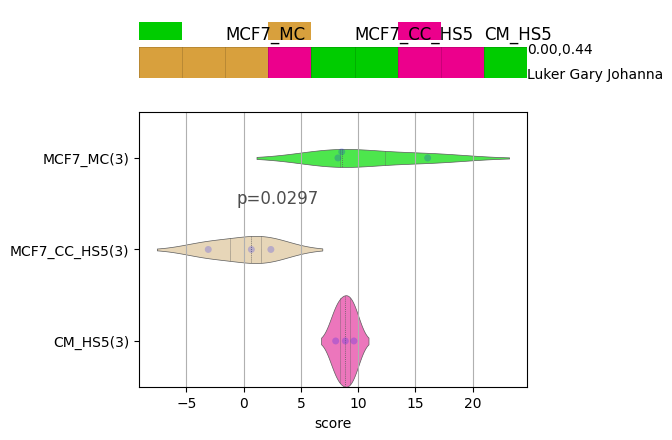

In [3]:
# import bone
reload(bone)
cfile = "/Users/sinha7290/public_html/BoNE/PRMT5_2.pdf"
pdf = getPDF(cfile)
ana = MacAnalysis()



cfile = 'PMID22530051.txt'
l1 = bone.getEntries(cfile, 0)
wt1, l1 = [1, -2], [l1[1:22], l1[24:]]




#ana.getLukerT47D()
ana.getLuker3HS5()
#ana.getLuker3HS27a()
#ana.getLuker3set()

#ana.getMCF7_GL()
#ana.getMCF7_NS()

#ana.getLuker3()
#ana.getLukerT47D()

#ana.getLuker3set()

#ana.getLukerCM()


###############
fig = processData(ana, l1, wt1, desc=None, violin=1)
pdf.savefig(transparent=True,bbox_inches = 'tight')
closePDF(pdf)

Luker 2021 bc (n = 73)
Luker Gary Johanna http://hegemon.ucsd.edu/Tools/explore.php?key=blood:leukemia&id=BC68
9 3 3 3 BC68
[39]


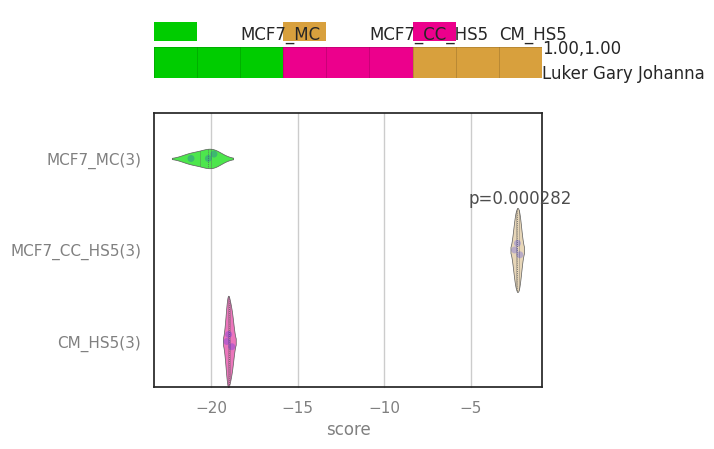

In [4]:
# import bone
reload(bone)
cfile = "/Users/sinha7290/public_html/BoNE/PRMT5_2.pdf"
pdf = getPDF(cfile)
ana = MacAnalysis()



wt1, l1 = [1], [bone.getEntries("Luker39.txt", 0)]





#ana.getLukerT47D()
ana.getLuker3HS5()
#ana.getLuker3HS27a()
#ana.getLuker3set()

#ana.getMCF7_GL()
#ana.getMCF7_NS()

#ana.getLuker3()
#ana.getLukerT47D()

#ana.getLuker3set()

#ana.getLukerCM()


###############
fig = processData(ana, l1, wt1, desc=None, violin=1)
pdf.savefig(transparent=True,bbox_inches = 'tight')
closePDF(pdf)

Luker 2021 bc (n = 73)
Luker Gary Johanna http://hegemon.ucsd.edu/Tools/explore.php?key=blood:leukemia&id=BC68
9 3 3 3 BC68
[39]


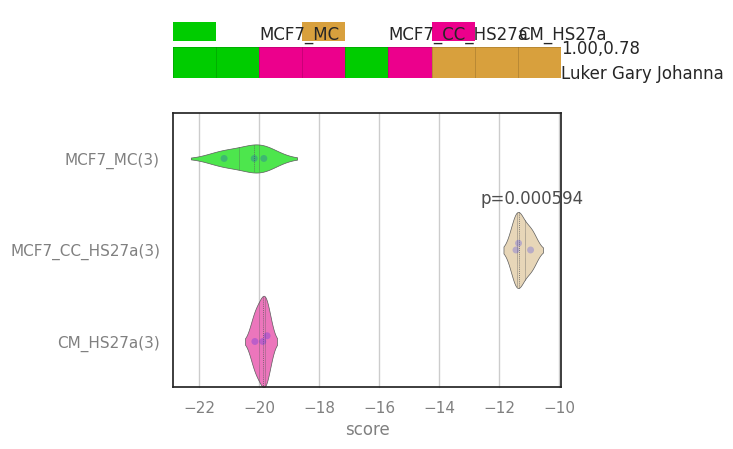

In [5]:
# import bone
reload(bone)
cfile = "/Users/sinha7290/public_html/BoNE/PRMT5_2.pdf"
pdf = getPDF(cfile)
ana = MacAnalysis()



wt1, l1 = [1], [bone.getEntries("Luker39.txt", 0)]





#ana.getLukerT47D()
#ana.getLuker3HS5()
ana.getLuker3HS27a()
#ana.getLuker3set()

#ana.getMCF7_GL()
#ana.getMCF7_NS()

#ana.getLuker3()
#ana.getLukerT47D()

#ana.getLuker3set()

#ana.getLukerCM()


###############
fig = processData(ana, l1, wt1, desc=None, violin=1)
pdf.savefig(transparent=True,bbox_inches = 'tight')
closePDF(pdf)

Luker 2021 bc (n = 73)
Luker Gary Johanna http://hegemon.ucsd.edu/Tools/explore.php?key=blood:leukemia&id=BC68
9 3 3 3 BC68
[39]


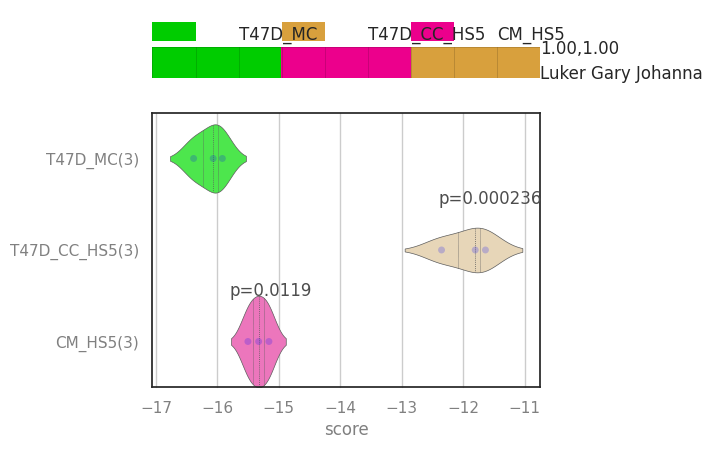

In [6]:
# import bone
reload(bone)
cfile = "/Users/sinha7290/public_html/BoNE/PRMT5_2.pdf"
pdf = getPDF(cfile)
ana = MacAnalysis()



wt1, l1 = [1], [bone.getEntries("Luker39.txt", 0)]



ana.getLuker4setT47D()

#ana.getLukerT47D()
#ana.getLuker3HS5()
#ana.getLuker3HS27a()
#ana.getLuker3set()

#ana.getMCF7_GL()
#ana.getMCF7_NS()

#ana.getLuker3()
#ana.getLukerT47D()

#ana.getLuker3set()

#ana.getLukerCM()


###############
fig = processData(ana, l1, wt1, desc=None, violin=1)
pdf.savefig(transparent=True,bbox_inches = 'tight')
closePDF(pdf)

Dhimolea2021 (n = 18)
GSE152312 http://hegemon.ucsd.edu/Tools/explore.php?key=blood:leukemia&id=SS61
12 6 6 0 SS61
[39]


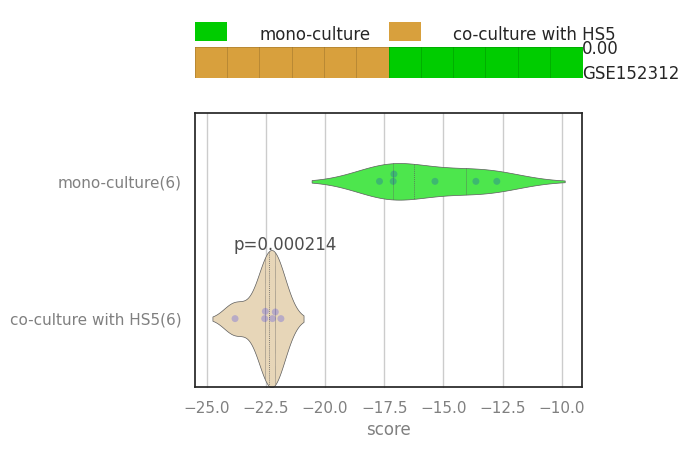

In [7]:
import bone
reload(bone)
cfile = "/Users/sinha7290/public_html/BoNE/PRMT5_2.pdf"
pdf = getPDF(cfile)
ana = MacAnalysis()



wt1, l1 = [1], [bone.getEntries("Luker39.txt", 0)]



ana.getDhimolea2021()

#ana.getLukerT47D()
#ana.getLuker3HS5()
#ana.getLuker3HS27a()
#ana.getLuker3set()

#ana.getMCF7_GL()
#ana.getMCF7_NS()

#ana.getLuker3()
#ana.getLukerT47D()

#ana.getLuker3set()

#ana.getLukerCM()


###############
fig = processData(ana, l1, wt1, desc=None, violin=1)
pdf.savefig(transparent=True,bbox_inches = 'tight')
closePDF(pdf)